In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import odeint

In [2]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, median_absolute_error

In [3]:
def mean_absolute_percentage_error(y_true, y_pred, eps = 1e-3): 
    # Avoid values too close to zero
    idxs = np.abs(y_true) > eps
    return np.mean(np.abs((y_true[idxs] - y_pred[idxs]) / y_true[idxs])) * 100 
#if y_true != 0 else 0.0

In [4]:
def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")

# 1. Discovering governing equations using the SINDy algorithm

Paper: https://www.pnas.org/content/113/15/3932

SINDy provides an algorithm to discover governing dynamical equations given a time series **x(t)**. The three steps in this algorithm are:
 - Time derivative: Perhaps the trickiest part, especially for noisy time series although one can use total variation regularized derivatives for such cases as in [here](https://github.com/stur86/tvregdiff)
 - Basis: Some non-linear basis of the original time series that could be polynomial, trigonometric (see the paper above)
 - Regularized linear regression: Apply LASSO and/or sequential thresholding least squares.
 
I have personally found that SINDy is not so good with series that are too noisy and/or have trends. Both these problems could be addressed using pre-processing.

SINDy can also be used for **forecasting**, which is trivial once one discovers the dynamical equations.

## Create synthetic dataset

Had trouble finding a good function. 

**REMEMBER**: change `dx1dt`, `dx2dt` also if you change the ranfun below.

In [5]:
def fun(y, t):
    x1, x2 = y
    dxdt = [-x1**3 - x2, x1 - x2**3]
    return dxdt

t_full = np.linspace(0, 15, 1501)

# The following two functions work great, with alpha = 0.0001, they are being correctly classified.
#y0 = [0.1, 0.05] # LINEAR: small x1, x2 => Linear coupled oscillator
y0 = [0.5, 0.5] # NON-LINEAR: Getting close to triggering non-linear effects

**Solve** the ODE:

$$
\begin{align}
\frac{dx_1}{dt} &= -x_1^3 - x_2 \\
\frac{dx_2}{dt} &= x_1 - x_2^3 
\end{align}
$$

In [6]:
sol = odeint(fun, y0, t_full)
sol_new = sol[:1001]

#### Plot the solutions

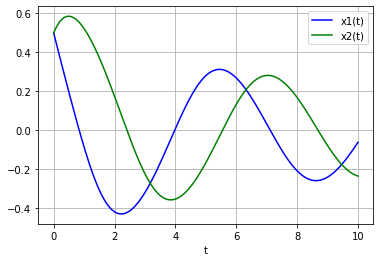

In [7]:
t_discover = t_full[:1001]

plt.plot(t_discover, sol_new[:, 0], 'b', label='x1(t)')
plt.plot(t_discover, sol_new[:, 1], 'g', label='x2(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()

## Step 1: Compute the time derivative. 

In [8]:
x1 = sol_new[:,0]
x2 = sol_new[:,1]

**Actual** time derivatives

In [9]:
dx1dt = -x1**3 - x2
dx2dt =  x1    - x2**3

**Numerically** computed derivatives from data

In [10]:
# 
dt = t_discover[1] - t_discover[0]
dx1dt_data = np.gradient(x1, dt)
dx2dt_data = np.gradient(x2, dt)
# or using TVRegDiff
# dx1dt = TVRegDiff(x1, 10, 0.1, dx=dt, plotflag=0)
# See https://github.com/stur86/tvregdiff 
# for information on different parameters

In [11]:
print_scores(dx1dt, dx1dt_data)

R2 score: 0.9999999965191242
MSE score: 2.8269156140981004e-10
MAE score: 4.206507155221408e-06
MAPE score: 0.0027874015339250414
Median AE score: 3.6181352647546294e-06


In [12]:
print_scores(dx2dt, dx2dt_data)

R2 score: 0.9999996026514059
MSE score: 2.195307457531667e-08
MAE score: 9.892101759080555e-06
MAPE score: 0.007423100308334605
Median AE score: 4.016199533329878e-06


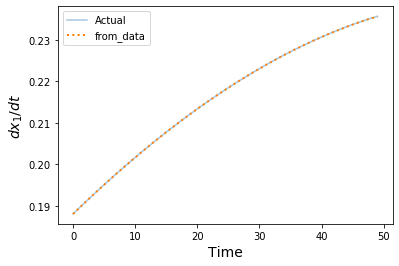

In [13]:
plt.plot(dx1dt[-50:], label='Actual', alpha=0.4)
plt.plot(dx1dt_data[-50:], ':', lw=2, label='from_data')

plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$dx_1/dt$', fontsize=14)
plt.legend()

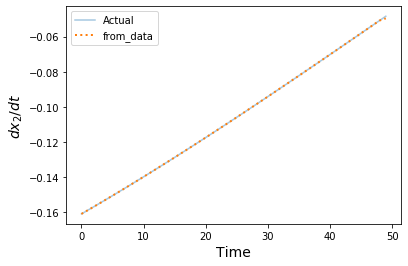

In [14]:
plt.plot(dx2dt[-50:], label='Actual', alpha=0.4)
plt.plot(dx2dt_data[-50:], ':', lw=2, label='from_data')

plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$dx_2/dt$', fontsize=14)
plt.legend()

Since the `np.gradient` derivatives are nearly identical to the original, I will be using the original derivatives.

In [15]:
X = np.zeros((sol_new.shape[0], sol_new.shape[1]))

X[:, 0] = x1 # dx1/dt
X[:, 1] = x2 # dx2/dt

## Step 2: Construct a polynomial (or trig) basis to do the regression

In [16]:
from sklearn.preprocessing import PolynomialFeatures

dum_data = pd.DataFrame(x1, columns=['x1'])
dum_data['x2'] = x2

deg = 3

p = PolynomialFeatures(degree=deg,include_bias=True).fit(dum_data)
xpoly = p.fit_transform(dum_data)
newdf = pd.DataFrame(xpoly, columns = p.get_feature_names(dum_data.columns))

print("Feature names:", list(newdf))#newdf.columns.values.tolist())
print("Feature array shape:", newdf.shape)

Feature names: ['1', 'x1', 'x2', 'x1^2', 'x1 x2', 'x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3']
Feature array shape: (1001, 10)


## Step 3: LASSO 

(or Ridge/OLS with sequential thresholding: that is first do the fit with Ridge/OLS. Then discard any features below a certain value. Do the fit again...)

low alpha -> OLS

high alpha -> most features zero

**alpha** is a hyperparameter

In [17]:
from sklearn import linear_model

mod = linear_model.Lasso(alpha=0.0001)
mod

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Prepare training data

In [18]:
newdf_train, newdf_test = newdf[:800], newdf[800:]
dx1dt_train, dx1dt_test = dx1dt[:800], dx1dt[800:]
dx2dt_train, dx2dt_test = dx2dt[:800], dx2dt[800:]

### dx1/dt

In [19]:
mod.fit(newdf_train, dx1dt_train)
print(mod.coef_) # should give the 3rd (x2) + 4th (x1^2) argument non-zero
print(mod.intercept_)
mod.score(newdf_test, dx1dt_test)

[ 0.         -0.05576026 -0.99852418  0.         -0.         -0.01819165
 -0.50202469 -0.          0.         -0.        ]
0.0033302444886464805


0.9943287924302203

In [20]:
fit_dx1 = pd.DataFrame(columns=newdf.columns)
fit_dx1.loc[0] = mod.coef_
fit_dx1.sort_values(by=0, axis=1) # ascending=False

,x2,x1^3,x1,x2^2,1,x1^2,x1 x2,x1^2 x2,x1 x2^2,x2^3
0,-0.998524,-0.502025,-0.05576,-0.018192,0.0,0.0,-0.0,-0.0,0.0,-0.0


In [21]:
ypred_x1 = mod.predict(newdf_test)
print_scores(dx1dt_test, ypred_x1)

R2 score: 0.9943287924302203
MSE score: 8.443005835967606e-05
MAE score: 0.009127412469564916
MAPE score: 18.75130365915868
Median AE score: 0.00942351242559783


### Identified ODE:

$dx_1/dt \sim -x_2 - x_1^3$

with minor contributions from other terms that could be gotten rid of by applying a threshold

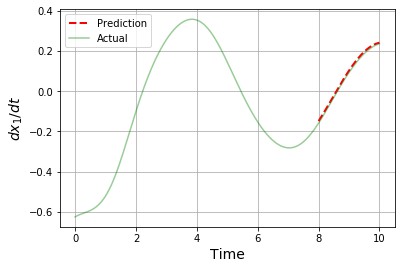

In [42]:
# PLOT results
t_test  = np.linspace(8, 10, 201)

#plt.plot(t, sol_new[:, 1], label='Actual', alpha = 0.4)
#plt.plot(ypred, label='Actual')
plt.plot(t_test, ypred_x1, 'r--', lw = 2, label='Prediction')
plt.plot(t_discover, dx1dt, 'g', label='Actual', alpha=0.4)
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$dx_1/dt$', fontsize=14)
plt.grid()
plt.legend()

### dx2/dt

In [23]:
mod.fit(newdf_train, dx2dt_train)
print(mod.coef_) # should give the 2nd (x1) + last (x2^3) argument non-zero
print(mod.intercept_)
mod.score(newdf_test, dx2dt_test)

[ 0.          0.99491832 -0.02198579 -0.         -0.         -0.04791986
  0.          0.         -0.         -0.82689872]
0.0022126622685510883


0.9965028656692734

In [24]:
fit_dx2 = pd.DataFrame(columns=newdf.columns)
fit_dx2.loc[0] = mod.coef_
fit_dx2.sort_values(by=0, axis=1) # ascending=False

,x2^3,x2^2,x2,1,x1^2,x1 x2,x1^3,x1^2 x2,x1 x2^2,x1
0,-0.826899,-0.04792,-0.021986,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.994918


In [25]:
ypred_x2 = mod.predict(newdf_test)
print_scores(dx2dt_test, ypred_x2)

R2 score: 0.9965028656692734
MSE score: 1.3128657613492761e-05
MAE score: 0.003284761866157685
MAPE score: 1.962931213051049
Median AE score: 0.0036951175861815594


### Identified ODE:

$dx_2/dt \sim x_1 - x_2^3$

with minor contributions from other terms that could be gotten rid of by applying a threshold

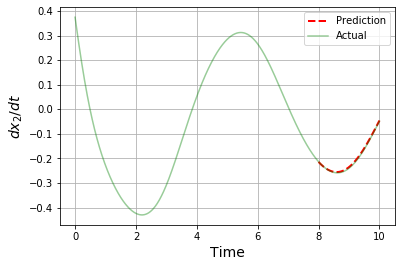

In [41]:
# PLOT results
t_test  = np.linspace(8, 10, 201)

#plt.plot(t, sol_new[:, 0], label='Actual', alpha = 0.4)
#plt.plot(ypred, label='Actual')
plt.plot(t_test, ypred_x2, 'r--', lw = 2, label='Prediction')
plt.plot(t_discover, dx2dt, 'g', label='Actual', alpha = 0.4)
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$dx_2/dt$', fontsize=14)
plt.grid()
plt.legend()

# 2. Forecasting using SINDy

Now that we have discovered the differential equations, we can use the ODE solver to forecast the future.

In [27]:
# Drop features with absolute values less than 0.1
dx1_thr = fit_dx1[fit_dx1.columns[fit_dx1.abs().max() > 0.1]]
dx1_thr

,x2,x1^3
0,-0.998524,-0.502025


In [28]:
#dx1_thr.values[0] # 1st row values

In [29]:
# Drop features with absolute values less than 0.1
dx2_thr = fit_dx2[fit_dx2.columns[fit_dx2.abs().max() > 0.1]]
dx2_thr

,x1,x2^3
0,0.994918,-0.826899


In [30]:
#dx2_thr.values[0] # 1st row values

In [31]:
# Could have also used features as a column
# fit_dx1.T.index.values
# or
# In that case, sorting would be done like this
#def lasso_imp(mod, df):
#    return pd.DataFrame({'Features':df.columns, 'Importance':mod.coef_}).sort_values('Importance', ascending=False)

#l_imp = lasso_imp(lasso_mod, )#, df.drop(flds, axis=1))
#to_keep = l_imp.iloc[l_imp['Importance'].abs().argsort()[::-1]].head(2)
#df_keep = df[to_keep['Features']].copy()
  
#X_train, X_test, y_train, y_test = train_test_seq(df_keep,df[fld],test_size=tst_sz)

#lasso_mod.fit(X_train,y_train)
#y_pred = lasso_mod.predict(X_test)

In [32]:
# Manually entering values for coefficients but this can be automated
def fun_forecast(y, t):
    x1, x2 = y
    dxdt = [-0.5*(x1**3) - 0.9985*x2, 
            0.995*x1     - 0.8269*x2**3]
    return dxdt

t_forecast = np.linspace(10, 15, 500)

y0 = [x1[-1], x2[-1]]

sol_forecast = odeint(fun_forecast, y0, t_forecast)

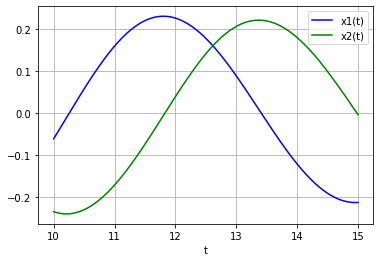

In [33]:
plt.plot(t_forecast, sol_forecast[:, 0], 'b', label='x1(t)')
plt.plot(t_forecast, sol_forecast[:, 1], 'g', label='x2(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()

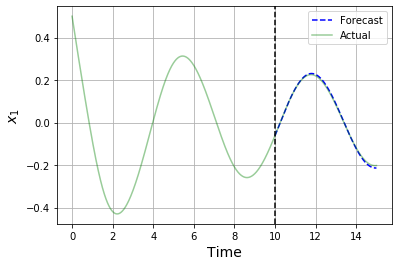

In [40]:
plt.plot(t_forecast, sol_forecast[:, 0], 'b--', label='Forecast')
plt.plot(t_full, sol[:, 0], 'g', label='Actual', alpha=0.4)
plt.axvline(x = 10, color='k', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$x_1$', fontsize=14)
plt.grid()

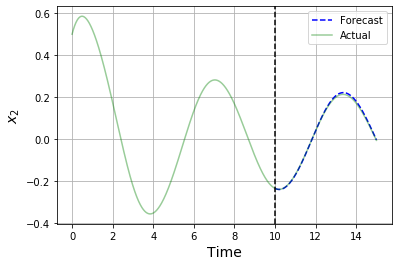

In [39]:
plt.plot(t_forecast, sol_forecast[:, 1], 'b--', label='Forecast')
plt.plot(t_full, sol[:, 1], 'g', label='Actual', alpha=0.4)
plt.axvline(x = 10, color='k', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$x_2$', fontsize=14)
plt.grid()

In [36]:
y_pred1, y_pred2 = sol_forecast[:, 0], sol_forecast[:, 1]
y_test1, y_test2 = sol[1001:, 0],      sol[1001:, 1]

In [37]:
for (y_test, y_pred) in zip([y_test1, y_test2], [y_pred1, y_pred2]):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")

R2 score: 0.9986014512322046
MSE score: 2.9194295629861532e-05
MAE score: 0.004498499556886438
MAPE score: 6.19710340252007
Median AE score: 0.004095611629683124
R2 score: 0.9988787480251635
MSE score: 2.8082044451838518e-05
MAE score: 0.004387715903581068
MAPE score: 5.44880830523028
Median AE score: 0.0032235369101030545
